In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

/Users/mwoods/Developer/open-ai-gym/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
env = gym.make('CartPole-v0')
path_to_recording = './tmp/CartPole-v0-gradient'


[2017-01-02 11:32:07,712] Making new env: CartPole-v0


In [3]:


def policy_gradient():
    
    """
    updates the policy gradient based on receiveing a state tensor and an action tensor 
    """
    state = tf.placeholder(dtype = tf.float32, shape = (None, 4))
    actions = tf.placeholder(dtype = tf.float32, shape  = (None, 2))
    advantage = tf.placeholder(dtype = tf.float32, shape  = (None, 1))
    
    linear_weights = tf.Variable(tf.zeros((4, 2)))
    linear = tf.matmul(state, linear_weights)
    est_probs = tf.nn.softmax(linear)
    
    acc = tf.reduce_sum(tf.mul(est_probs, actions), reduction_indices = [1])
    log_probs = tf.log(acc)
    loss = -tf.reduce_sum(log_probs * advantage)
    optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
    
    return optimizer, state, actions, advantage, est_probs, loss, linear_weights


def value_gradient():
    """
    a 2 layer Feed Forward Net to estimate the value as a function of the state vector
    """
    state = tf.placeholder(dtype=tf.float32, shape = (None, 4))
    val = tf.placeholder(dtype=tf.float32, shape = (None, 1))
    
    w1 = tf.Variable(tf.random_normal([4, 10]))
    b1 = tf.Variable(tf.zeros([10]))
    h1 = tf.nn.relu(tf.matmul(state, w1) + b1)
    
    w2 = tf.Variable(tf.random_normal([10, 1]))
    b2 = tf.Variable(tf.zeros([1]))
    val_est = tf.matmul(h1, w2) + b2
    
    loss = tf.nn.l2_loss(val_est - val)
    optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
    return optimizer, state, val, val_est, loss


In [4]:
policy_opt, policy_state_var, policy_action_var, policy_advantages_var,  policy_action_est, policy_loss, wts = policy_gradient()
value_opt, value_state_var, value_val_var, value_val_est, value_loss = value_gradient()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

TOTAL_NUMBER_OF_TRAINING_EPISODES = 0

In [5]:
num_episodes = 1000
gamma = 0.97

pol_loss_hist = []
val_loss_hist = []
reward_hist = []
 
print 'Total # of episodes trained so far', TOTAL_NUMBER_OF_TRAINING_EPISODES
for epoch in xrange(num_episodes):
    TOTAL_NUMBER_OF_TRAINING_EPISODES += 1
    obs = env.reset()
    states = []
    actions = []
    transitions = []
    total_reward = 0.0
    eps = 1.0/(epoch + 4.0)
    
    while True:
        probs = sess.run(policy_action_est, feed_dict={policy_state_var : obs.reshape((1, obs.shape[0]))})
        #if np.random.rand() > probs.max():
        #    action = env.action_space.sample()
        #else:
        #    action = 0 if (probs[0][0] > 0.5) else 1
        #print probs
        #THIS EXPLORATION FUNCTION IS THE MOST CRITICAL PART TO THE SUCCESS of the model. WHY???
        action = 0 if np.random.rand() < probs[0][0] else 1 #intresting approach.. as you get more confident in your answers the model will start to scale down
        #print obs
        #print action, probs
        
        action_arr = np.zeros(2)
        action_arr[action] = 1.0

        next_obs, reward, done, _ = env.step(action)

        states.append(obs)
        actions.append(action_arr)
        transitions.append((next_obs, reward, done))

        total_reward += reward

        obs = next_obs
        if done or total_reward > 500:
            break
    
    
    future_rewards = []
    for idx, trans in enumerate(transitions):
        obs, rew, done = trans
        cum_reward = 0.0
        for idx2, future_trans in enumerate(transitions[idx:]):
            _, future_reward, _ = future_trans
            #print (gamma**idx2) * future_reward
            cum_reward += (gamma**idx2) * future_reward
        
        future_rewards.append([cum_reward])
    

    #calculate the difference between the true reward and the estimated value
    #if the policy suggests an action, but the true future reward is worse than the predicted result, then it will increase
    #the loss score, which will pull the policy in the other direction
    
    obs_ = [obs for obs, _, _ in  transitions]
    estimated_val = sess.run(value_val_est, feed_dict = {value_state_var : obs_})
    future_rewards =  np.array(future_rewards)
    #future_rewards = (future_rewards - future_rewards.mean())/future_rewards.std()
    
    advantage = (future_rewards - estimated_val)

    pol_opt, pol_loss = sess.run([policy_opt, policy_loss], feed_dict = {policy_state_var: states, 
                                                                         policy_action_var: actions,
                                                                         policy_advantages_var: advantage
                                                                        })
    
    val_opt, val_loss = sess.run([value_opt, value_loss], feed_dict = {value_state_var: states, value_val_var: future_rewards})
    
    pol_loss_hist.append(pol_loss)
    val_loss_hist.append(val_loss)
    reward_hist.append(total_reward)
    if epoch % 10 == 0:
        print 'episode', epoch, 'total_reward', total_reward, pol_loss, val_loss
    
    if sum(reward_hist[-100:])/100.0 > 250:
        break
        

print 'Total # of episodes trained so far', TOTAL_NUMBER_OF_TRAINING_EPISODES

Total # of episodes trained so far 0
episode 0 total_reward 26.0 5309.24 1926.91
episode 10 total_reward 14.0 684.574 320.81
episode 20 total_reward 28.0 5608.76 1916.51
episode 30 total_reward 15.0 855.533 298.732
episode 40 total_reward 17.0 799.999 382.531
episode 50 total_reward 29.0 5003.87 1663.88
episode 60 total_reward 34.0 7564.53 2283.0
episode 70 total_reward 49.0 18505.4 4591.11
episode 80 total_reward 61.0 31909.6 7138.27
episode 90 total_reward 95.0 96639.6 15720.8
episode 100 total_reward 23.0 687.25 390.965
episode 110 total_reward 25.0 445.415 376.218
episode 120 total_reward 41.0 4705.07 1638.93
episode 130 total_reward 48.0 6980.62 1864.72
episode 140 total_reward 20.0 -1254.59 408.305
episode 150 total_reward 34.0 -609.118 730.929
episode 160 total_reward 29.0 -2167.55 772.597
episode 170 total_reward 61.0 6302.44 2377.14
episode 180 total_reward 29.0 -2621.52 931.418
episode 190 total_reward 54.0 4117.12 1415.06
episode 200 total_reward 69.0 11504.9 2330.47
episode

In [6]:
#env = gym.make('CartPole-v0')
#path_to_recording = './tmp/CartPole-v0-gradient'

env = gym.make('CartPole-v1')
path_to_recording = './tmp/CartPole-v1-gradient'

#env.monitor.start(path_to_recording, force = True)

[2017-01-02 11:32:31,195] Making new env: CartPole-v1


In [8]:
for i in xrange(201):
    obs = env.reset()
    total_reward = 0.0
    while True:
        probs = sess.run(policy_action_est, feed_dict={policy_state_var : obs.reshape((1, obs.shape[0]))})
        action = 0 if 0.5 < probs[0][0] else 1
        obs, reward, done, _ = env.step(action)
        total_reward += reward
        if done or total_reward > 500:
            break
    if i % 25 == 0:
        print 'episode', i, 'reward', total_reward

        

episode 0 reward 501.0
episode 25 reward 501.0
episode 50 reward 501.0
episode 75 reward 501.0
episode 100 reward 501.0
episode 125 reward 501.0
episode 150 reward 501.0
episode 175 reward 501.0
episode 200 reward 501.0


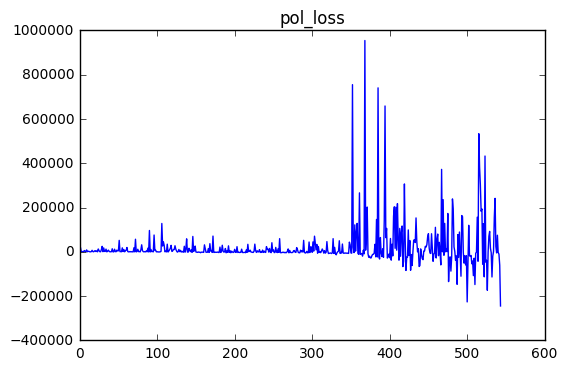

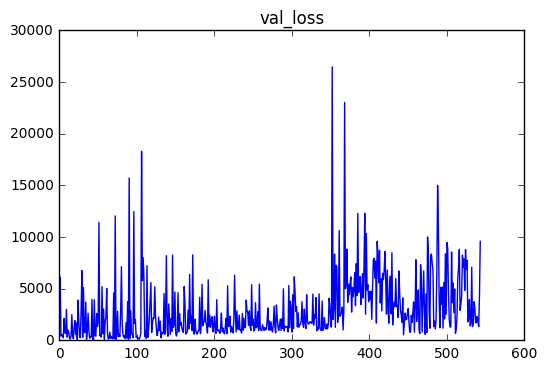

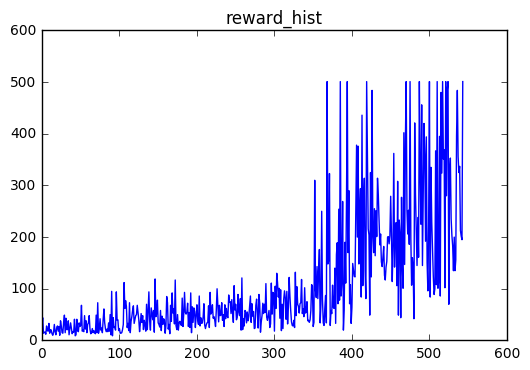

In [9]:
plt.plot(pol_loss_hist)
plt.title("pol_loss")
plt.show()

plt.plot(val_loss_hist)
plt.title("val_loss")
plt.show()

plt.plot(reward_hist)
plt.title("reward_hist")
plt.show()

In [10]:
sum(reward_hist[-100: ])/100.0


252.34

In [11]:
#env.monitor.close()